In [1]:
import numpy as np

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import cv2
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# Plots
import matplotlib.pyplot as plt

# Utils
from tqdm import tqdm, trange
import os

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [3]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
t, r, a, f

(4294967296, 0, 0, 0)

In [4]:
torch.cuda.empty_cache()

## Utils

# Load data

root
- 0
    - img1
    - img2
    - img3
- 1
    - img1
    - img2
    - img3

In [14]:
# The ImageFolder dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: torch.flatten(x.T))])
#transform = transforms.Compose([])
dataset = torchvision.datasets.ImageFolder('../datasets/money/', transform=transform)

In [17]:
next(iter(dataset))[0].shape

torch.Size([49152])

In [18]:
sample_loader = DataLoader(dataset, batch_size = 32, shuffle = True)
samples =next(iter(sample_loader))[0]
samples.shape

torch.Size([32, 49152])

In [19]:
samples.max(), samples.min()

(tensor(1.), tensor(0.))

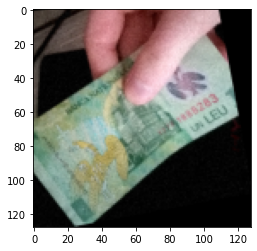

In [20]:
plt.imshow(samples[0].reshape(128, 128, 3))

In [21]:
dataset.classes

['100_aug', '1_aug']

In [22]:
from torch.utils.data import random_split
train_len = int(.8 * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# Classes

In [23]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, output_dim)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return F.softmax(x, dim = 1)

# Training

In [24]:
input_shape = tuple(next(iter(dataset))[0].shape)[0]
output_shape = len(dataset.classes)
model = Model(input_shape, output_shape)
model.cuda()

Model(
  (fc1): Linear(in_features=49152, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)

In [25]:
summary(model, input_size = (input_shape, ), batch_size = 32, device = "cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [32, 1024]      50,332,672
              ReLU-2                 [32, 1024]               0
            Linear-3                  [32, 512]         524,800
              ReLU-4                  [32, 512]               0
            Linear-5                  [32, 128]          65,664
              ReLU-6                  [32, 128]               0
            Linear-7                    [32, 2]             258
Total params: 50,923,394
Trainable params: 50,923,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.00
Forward/backward pass size (MB): 0.81
Params size (MB): 194.26
Estimated Total Size (MB): 201.07
----------------------------------------------------------------


In [26]:
for p in model.parameters():
    print(p.shape)
    #print(p)

torch.Size([1024, 49152])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([128, 512])
torch.Size([128])
torch.Size([2, 128])
torch.Size([2])


In [15]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_function = nn.CrossEntropyLoss()

In [16]:
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [17]:
epochs = 50
batch_size = 64
accs = []
losses = []
val_accs = []
val_losses = []
model.train()
for epoch in (t:= trange(epochs)):
    # Get batches
    model.train()
    loss = 0.
    acc = 0.
    num_batches = 0
    for X_batch, y_batch in trainloader:
        num_batches+=1
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        y_pred = model(X_batch)
        
        loss_batch = loss_function(y_pred, y_batch)    
        loss += loss_batch.item()
        acc += accuracy_score(torch.argmax(y_pred.cpu(), axis = 1), y_batch.cpu())
        
        optimizer.zero_grad() # don't forget this
        loss_batch.backward()
        optimizer.step()

    acc /= num_batches
    loss /= num_batches
    losses.append(loss)
    accs.append(acc)
    
    # Validation set
    model.eval()
    num_batches = 0
    val_acc = 0.
    val_loss = 0.
    for X_batch, y_batch in testloader:
        num_batches+=1
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        
        y_pred = model(X_batch)
        val_acc += accuracy_score(torch.argmax(y_pred.cpu(), axis = 1), y_batch.cpu())
        loss_batch = loss_function(y_pred, y_batch)    
        val_loss += loss_batch.item()
        
    val_acc /= num_batches
    val_loss /= num_batches
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    t.set_description(f"(Loss, Acc) --Training : {round(loss, 2), round(acc, 2)}, Test : {round(val_loss, 2), round(val_acc, 2)}")
    

(Loss, Acc) --Training : (0.38, 0.93), Test : (0.48, 0.83): 100%|█| 50/


In [18]:
del X_batch, y_batch
torch.cuda.empty_cache()

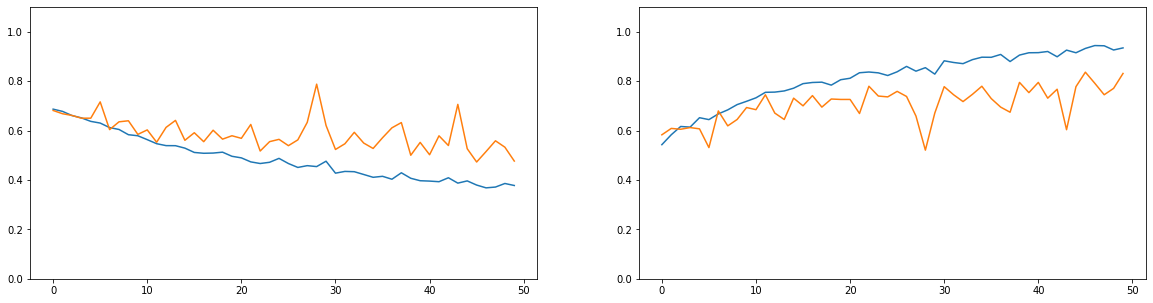

In [19]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))

axs[0].set_ylim(0, 1.1)
axs[0].plot(losses)
axs[0].plot(val_losses)

axs[1].set_ylim(0, 1.1)
axs[1].plot(accs)
axs[1].plot(val_accs)

